# Stock Price Indicator

## Project Overview

Student provides a high-level overview of the project. Background information such as the problem domain, the project origin, and related data sets or input data is provided.


Investment firms, hedge funds and even individuals have been using financial models to better understand market behavior and make profitable investments and trades. A wealth of information is available in the form of historical stock prices and company performance data, suitable for machine learning algorithms to process.


Here, I build a stock price predictor that takes daily trading data over a certain date range as input, and outputs projected estimates for given query dates. Inputs contain multiple metrics:
 * opening price (Open)
 * highest price the stock traded at (High)
 * how many stocks were traded (Volume)
Whereas the prediction is made on:
 * closing price adjusted for stock splits and dividends (Adjusted Close)

We want to explore, where possible, S&P500 companies. The list of the listed companies is taken from [here](https://datahub.io/core/s-and-p-500-companies). 
The trading data comes from [Quandl End-of-Day US stock prices](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices) and it is downloaded through their [API](https://www.quandl.com/data/EOD-End-of-Day-US-Stock-Prices/usage/quickstart/api) and stored locally. Details are provided into the `Data Exploration` section below.

#### Project Format and Features
The project is developed in the form of a simple script.
<br/>EXTRA: (and any additions/modifications you want to make to the project (e.g. suggesting what trades to make))


## Problem Statement

The problem which needs to be solved is clearly defined. A strategy for solving the problem, including discussion of the expected solution, has been made.

## Metrics

Metrics used to measure performance of a model or result are clearly defined. Metrics are justified based on the characteristics of the problem.

## Requirements

In [1]:
# basics
import os
# data
import json
import numpy as np
import pandas as pd
# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,log_loss,regression
# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# settings
sns.set(style="white")

# data folder
data_folder = os.path.join(os.getcwd(),"..\\data")
costituents_fn = "constituents_csv.csv"
tickers_fn = "tickers.json"
dataset_fn = "dataset.csv"
data_folder

'C:\\dev\\dsnd-spi\\nbooks\\..\\data'

In [2]:
df = pd.read_csv(os.path.join(data_folder,dataset_fn), parse_dates=['Date'], index_col='Unnamed: 0',)
with open(os.path.join(data_folder,tickers_fn)) as f:
    tickers = json.load(f)
df.head()

,Date,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume,Ticker
0,2017-12-28,171.00,171.850,170.480,171.08,16480187.0,0.0,1.0,165.971205,166.796208,165.466497,166.048853,16480187.0,AAPL
1,2017-12-27,170.10,170.780,169.710,170.60,21498213.0,0.0,1.0,165.097672,165.757675,164.719142,165.582968,21498213.0,AAPL
2,2017-12-26,170.80,171.470,169.679,170.57,33185536.0,0.0,1.0,165.777087,166.427383,164.689053,165.553851,33185536.0,AAPL
3,2017-12-22,174.68,175.424,174.500,175.01,16349444.0,0.0,1.0,169.542983,170.265103,169.368277,169.863278,16349444.0,AAPL
4,2017-12-21,174.17,176.020,174.100,175.01,20949896.0,0.0,1.0,169.047981,170.843576,168.980040,169.863278,20949896.0,AAPL


## Analysis

### Data Exploration

Features and calculated statistics relevant to the problem have been reported and discussed related to the dataset, and a thorough description of the input space or input data has been made. Abnormalities or characteristics about the data or input that need to be addressed have been identified.

Here, we explore the data by referring to the CRISP-DM methodology.

### Data Visualization

Build data visualizations to further convey the information associated with your data exploration journey. Ensure that visualizations are appropriate for the data values you are plotting.


In [3]:
# verifying data integrity and basic stats
print(df.isna().sum())
df.describe()

Date          0
Open          0
High          0
Low           0
Close         0
Volume        0
Dividend      0
Split         0
Adj_Open      0
Adj_High      0
Adj_Low       0
Adj_Close     0
Adj_Volume    0
Ticker        0
dtype: int64


,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
count,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,31610.000000,3.161000e+04
mean,95.491669,96.171887,94.818211,95.521521,1.226938e+07,0.009154,1.000316,81.437157,82.014518,80.866317,81.463475,1.286934e+07
std,59.333158,59.766797,58.916946,59.355129,1.500732e+07,0.085350,0.038147,43.340742,43.637986,43.056648,43.358424,1.609089e+07
min,17.350000,17.400000,17.250000,17.360000,3.053580e+05,0.000000,1.000000,16.190719,16.250819,16.102600,16.186081,3.053580e+05
25%,55.372500,55.870000,54.980000,55.395000,3.847515e+06,0.000000,1.000000,47.642711,48.065195,47.263770,47.650090,4.104089e+06
50%,87.845000,88.400000,87.170000,87.840000,7.197633e+06,0.000000,1.000000,76.139854,76.664216,75.628460,76.147526,7.490536e+06
75%,118.560000,119.290000,117.707500,118.580000,1.526566e+07,0.000000,1.000000,105.912443,106.673449,105.180398,105.948241,1.574847e+07
max,649.900000,651.260000,644.470000,647.350000,6.166205e+08,3.290000,7.000000,286.481931,286.913264,284.785353,285.542583,6.166205e+08


In [4]:
# check whether the period is shared across companies, bringin together first date, last date and the difference between the two
m = pd.merge(
    pd.merge(
        df.groupby('Ticker')['Date'].min(),
        df.groupby('Ticker')['Date'].max(),
        left_index=True,
        right_index=True),
    df.groupby('Ticker')['Date'].max()-df.groupby('Ticker')['Date'].min(),
    left_index=True,
    right_index=True
)
m.columns = ['start date','end date', 'difference']
m

,start date,end date,difference
Ticker,,,
AAPL,2013-09-03,2017-12-28,1577 days
AXP,2013-09-03,2017-12-28,1577 days
BA,2013-09-03,2017-12-28,1577 days
CAT,2013-09-03,2017-12-28,1577 days
CSCO,2013-09-03,2017-12-28,1577 days
CVX,2013-09-03,2017-12-28,1577 days
DIS,2013-09-03,2017-12-28,1577 days
GE,2013-09-03,2017-12-28,1577 days
GS,2013-09-03,2017-12-28,1577 days


C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


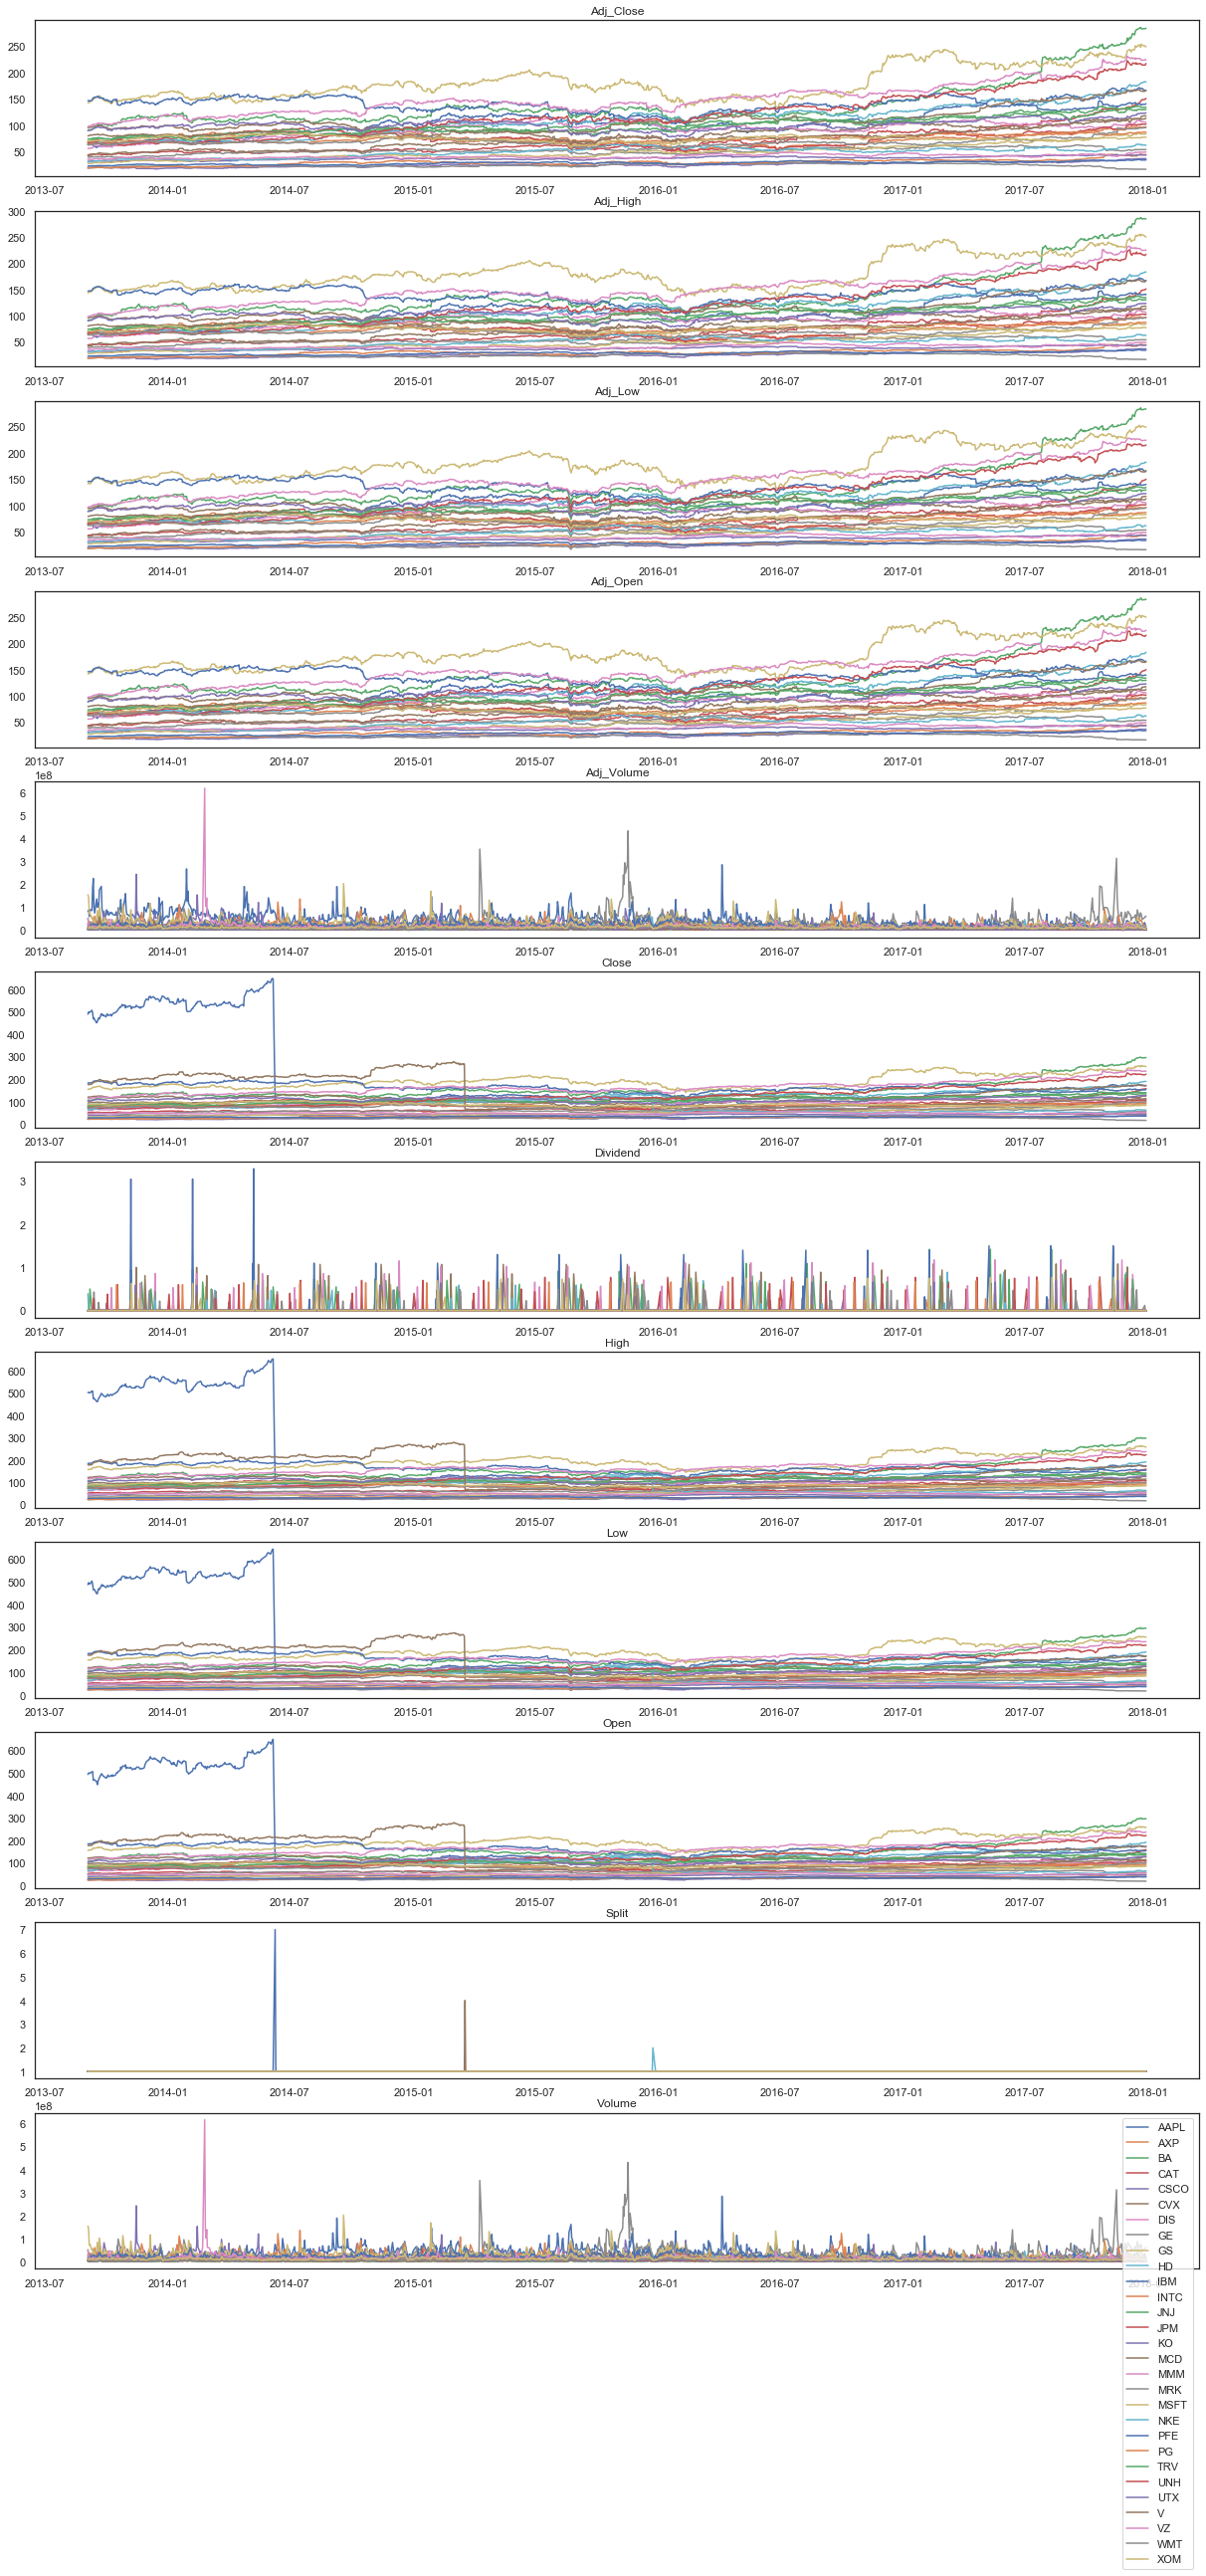

In [5]:
# plot timeseries by company
cols_to_plot = list(set(df.columns) - set(['Ticker', 'Date']))
cols_to_plot.sort()
gs = df.groupby('Ticker')

fig,axs = plt.subplots(nrows=len(cols_to_plot),ncols=1,figsize=(17,32))
plt.tight_layout()

for col,ax in zip(cols_to_plot,axs):
    for n,g in gs:
        x = g['Date']
        y = g[col]
        ax.plot(x,y,label=n)
        ax.set_title(col)
    # print legend once
    if col == cols_to_plot[-1]:
        ax.legend()

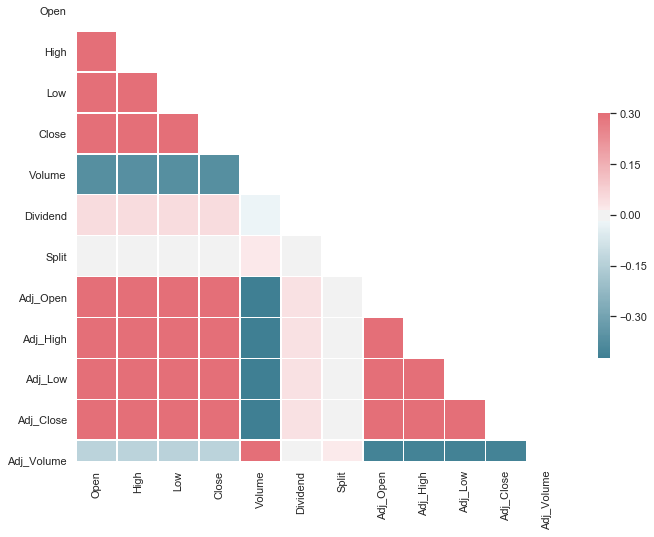

In [6]:
# plot correlation matrix
df_gen = df.drop(columns=['Ticker','Date'])
corr = df_gen.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr,vmax=.3, center=0,cmap=cmap, mask=mask,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Methodology

### Data Preprocessing

Preprocessing steps consist of:
* **scaling (standardization)**: whereas stock prices and dividends are of similar nature (currency), volume and split occur at a different unit.
* **windowing**: as the data comes in the form of a time series, it is required to be stored as an time-related array of features.
* **closing price projection**: we extract the adjusted closing price for each window, at 1, 7, 14 and 28 days.
* **split**: train and test datasets are created in a ratio of 70-30.

### Implementation

Here, I fit a RandomForestRegressor to predict a 4-class vector which represent the closing stock price at 1,7,14 and 28 days. Eventually, 4 different models which handle 1-d output might be trained for the scope. Here, GridSearch is not performed yet, as it might lead to a data leak due to the previous scaling. Mean squared error is used to evaluate the model performances on the training and test sets.

### Refinement

As the first model performance shows a clear overfitting (MSE on training is about 6 times lower than the MSE on the test set). Therefore, I repeat what above, but by building a pipeline object which comprehends a scaler to then perform a grid search to tune the hyper-parameters. Therefore, the windowing is done again, but omitting the scaling.

In [ ]:
def preprocess_data(df, window, to_drop=['Date','Ticker'], y_label='Adj_Close', grouper='Ticker'):
    """ Trim data by a given time window, and the associated the adjusted closing price at 1,7,14 and 28 days.
    
    Parameters
    ----------
    df : DataFrame
        data
    
    window : int
        window size (days)
    
    to_drop : array-like
        [optional] column names to drop, default=['Date','Ticker']
    
    y_label : str
        [optional] label to predict, default='Adj_Close'
    
    grouper : string
        [optional] name of the column which represents the company - typically, the ticker, default='Ticker'
    
    Returns
    -------
    X : array
        input tensor for the specificed window. If data is of shape (n,m), X will have shape (n,w,m)
        NOTE: m is the numer of features, but the ones to drop
    
    y : array
        output vector for the adjusted closing price at 1,7,14 and 28 days, of shape=(n,1,4)
    """
    # SCALE
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    # X works on the whole df, minus the non-numeric columns
    scaler_X.fit(df.drop(columns=to_drop,inplace=False))
    # y on a vector shape (4,) (4 times y_label)
    scaler_y.fit(pd.concat([df[y_label]]*4,axis=1))
    
    # WINDOWING
    groups = df.groupby(grouper)
    X = []
    y = []
    
    for n,g in groups:
        # NOTE: we could add a company-related information (e.g. volatility index)
        for i in range(window, len(g)-28):
            g = g.reset_index(drop=True)
            # drop and transform X
            data = scaler_X.transform(g[i-window:i].drop(columns=to_drop,inplace=False))
            # transform y - remember to increase dimensionality of the array
            pred = np.expand_dims(np.array([g.loc[i+1,y_label],g.loc[i+7,y_label],g.loc[i+14,y_label],g.loc[i+28,y_label]]),0)
            pred = scaler_y.transform(pred)
            # done-
            X.append(data)
            y.append(pred)
                 
    return np.array(X),np.array(y),scaler_y

X,y,scaler_y = preprocess_data(df,5)

In [ ]:
df.shape, X.shape, y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, shuffle=False)

mdl = RandomForestRegressor()
mdl.fit(X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2])),y_train.reshape(y_train.shape[0],4))

print(mdl)

# predictions
y_train_pred = mdl.predict(X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2])))
y_pred_test = mdl.predict(X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2])))
# performances
mse_train = regression.mean_squared_error(y_train.reshape(y_train.shape[0],4),y_train_pred)
mse_test  = regression.mean_squared_error(y_test.reshape(y_test.shape[0],4),y_pred_test)

print()
print("TRAIN Mean Squared Error:",mse_train)
print("TEST  Mean Squared Error:",mse_test)

In [ ]:
days=[1,7,14,28]

for i in range(len(days)):

    y1=scaler_y.inverse_transform(y_pred_test).T[i]
    y2=scaler_y.inverse_transform(y_test).T[i][0]
    x=np.arange(len(y1))

    fig = plt.figure(figsize=(12,3))
    plt.plot(x,y1,label='pred')
    plt.plot(x,y2,label='truth')
    plt.title('Adjusted Close Price @ {} days'.format(days[i]))
    plt.legend()

#### Refinement

In [ ]:
def window_data(df, window, to_drop=['Date','Ticker'], y_label='Adj_Close', grouper='Ticker'):
    """ Trim data by a given time window, and the associated the adjusted closing price at 1,7,14 and 28 days.
    
    Parameters
    ----------
    df : DataFrame
        data
    
    window : int
        window size (days)
    
    to_drop : array-like
        [optional] column names to drop, default=['Date','Ticker']
    
    y_label : str
        [optional] label to predict, default='Adj_Close'
    
    grouper : string
        [optional] name of the column which represents the company - typically, the ticker, default='Ticker'
    
    Returns
    -------
    X : array
        input tensor for the specificed window. If data is of shape (n,m), X will have shape (n,w,m)
        NOTE: m is the numer of features, but the ones to drop
    
    y : array
        output vector for the adjusted closing price at 1,7,14 and 28 days, of shape=(n,1,4)
    """
    # WINDOWING
    groups = df.groupby(grouper)
    X = []
    y = []
    
    for n,g in groups:
        # NOTE: we could add a company-related information (e.g. volatility index)
        for i in range(window, len(g)-28):
            g = g.reset_index(drop=True)
            # drop and transform X
            data = g[i-window:i].drop(columns=to_drop,inplace=False)
            # transform y - remember to increase dimensionality of the array
            pred = np.expand_dims(np.array([g.loc[i+1,y_label],g.loc[i+7,y_label],g.loc[i+14,y_label],g.loc[i+28,y_label]]),0)
            # done-
            X.append(data)
            y.append(pred)
                 
    return np.array(X),np.array(y)

X2,y2 = window_data(df,5)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, train_size=0.7, random_state=42, shuffle=False)

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', RandomForestRegressor())
])

params = {
    'reg__max_depth':[8,10,12],
    'reg__min_samples_leaf':[2,3,4],
    'reg__min_samples_split':[4,5,6]
}

cv = GridSearchCV(pipeline, param_grid=params)
cv.fit(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2])),y_train2.reshape(y_train2.shape[0],4)
)

mdl2 = cv.best_estimator_
print(mdl2)

y_pred_train2 = mdl2.predict(
    X_train2.reshape((X_train2.shape[0],X_train2.shape[1]*X_train2.shape[2]))
)
y_pred_test2 = mdl2.predict(
    X_test2.reshape((X_test2.shape[0],X_test2.shape[1]*X_test2.shape[2]))
)

mse_train2 = regression.mean_squared_error(y_train2.reshape(y_train2.shape[0],4),y_pred_train2)
mse_test2  = regression.mean_squared_error(y_test2.reshape(y_test2.shape[0],4),y_pred_test2)

print("TRAIN Mean Squared Error:",mse_train2)
print("TEST  Mean Squared Error:",mse_test2)

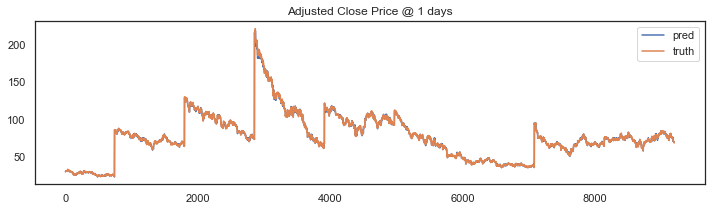

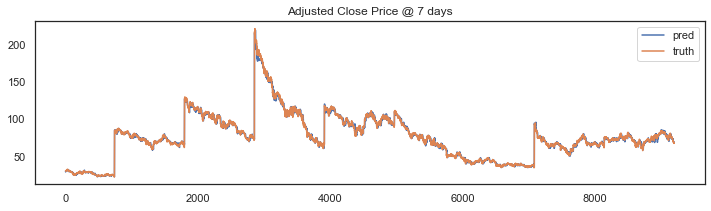

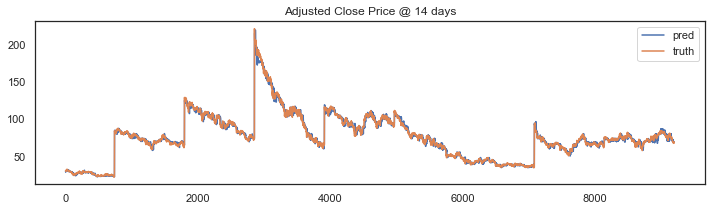

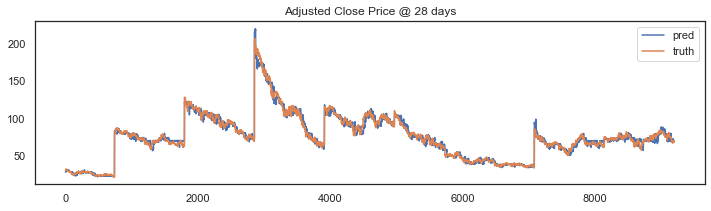

In [66]:
days=[1,7,14,28]

for i in range(len(days)):
    y1=scaler_y.inverse_transform(y_pred_test2).T[i]
    y2=scaler_y.inverse_transform(y_test2).T[i][0]
    x=np.arange(len(y1))

    fig = plt.figure(figsize=(12,3))
    plt.plot(x,y1,label='pred')
    plt.plot(x,y2,label='truth')
    plt.title('Adjusted Close Price @ {} days'.format(days[i]))
    plt.legend()

## Results

### Model Evaluation and Validation

If a model is used, the following should hold: The final model’s qualities — such as parameters — are evaluated in detail. Some type of analysis is used to validate the robustness of the model’s solution.

Alternatively a student may choose to answer questions with data visualizations or other means that don't involve machine learning if a different approach best helps them address their question(s) of interest.

### Justification

The final results are discussed in detail.
Exploration as to why some techniques worked better than others, or how improvements were made are documented.

## Conclusion

### Reflection

Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

### Improvement

Discussion is made as to how at least one aspect of the implementation could be improved. Potential solutions resulting from these improvements are considered and compared/contrasted to the current solution.

In [64]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('reg', AdaBoostRegressor())
])

params = {
    'reg__n_estimators':[40,50,70],
    'reg__learning_rate':[0.2,0.8,1.5]
}

cv = GridSearchCV(pipeline, param_grid=params)
cv.fit(
    X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2])),y_train.reshape(y_train.shape[0],4)
)

mdl2 = cv.best_estimator_
print(mdl2)

y_pred_train2 = mdl2.predict(
    X_train.reshape((X_train.shape[0],X_train.shape[1]*X_train.shape[2]))
)
y_pred_test2 = mdl2.predict(
    X_test.reshape((X_test.shape[0],X_test.shape[1]*X_test.shape[2]))
)

mse_train = regression.mean_squared_error(y_train.reshape(y_train.shape[0],4),y_pred_train2)
mse_test  = regression.mean_squared_error(y_test.reshape(y_test.shape[0],4),y_pred_test2)

print("TRAIN Mean Squared Error:",mse_train)
print("TEST  Mean Squared Error:",mse_test)

C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\claud\Anaconda3\envs\dsnd_spi\lib\site-packages\sklearn\model_selection\_validation.py:530: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: bad input shape (14304, 4)